# Analyze all the results generated by the experiments
After each of the experiments have been run, this notebook computes results and formats them into charts and tables for publication or analysis.

## Imports

In [1]:
import os
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Experiment 0: Observation Models & Individual Mode Evaluation

### Analyze audio scene observation model $p(Z_{scene,aud}|X_{scene,aud})$

In [2]:
raw_audio_scene_model_df = pd.read_csv('../../results/exp0_obs_models/scene_recognition/cpjku_audio_scene_obs_model_raw.csv',index_col=0)
rank = np.linalg.matrix_rank(raw_audio_scene_model_df.to_numpy())

In [3]:
raw_audio_scene_model_df

,airport,bus,metro,metro_station,park,public_square,shopping_mall,street_pedestrian,street_traffic,tram
campus,12.0,18.0,48.0,13.0,205.0,6.0,0.0,0.0,36.0,1940.0
courtyard,5.0,273.0,8.0,10.0,766.0,2.0,1.0,1.0,18.0,1381.0
lab,15.0,156.0,2110.0,42.0,79.0,1.0,0.0,0.0,64.0,30.0
lobby,478.0,56.0,190.0,467.0,973.0,0.0,67.0,17.0,20.0,174.0


In [4]:
rank

4

Matrix is full rank.

In [5]:
smoothed_audio_scene_model_df = pd.read_csv('../../results/exp0_obs_models/scene_recognition/cpjku_audio_scene_obs_model_smoothed.csv',index_col=0)
smoothed_audio_scene_model_df

,airport,bus,metro,metro_station,park,public_square,shopping_mall,street_pedestrian,street_traffic,tram
campus,13.0,19.0,49.0,14.0,206.0,7.0,1.0,1.0,37.0,1941.0
courtyard,6.0,274.0,9.0,11.0,767.0,3.0,2.0,2.0,19.0,1382.0
lab,16.0,157.0,2111.0,43.0,80.0,2.0,1.0,1.0,65.0,31.0
lobby,479.0,57.0,191.0,468.0,974.0,1.0,68.0,18.0,21.0,175.0


In [6]:
norm_audio_scene_model_df = pd.read_csv('../../results/exp0_obs_models/scene_recognition/cpjku_audio_scene_obs_model_normalized.csv',index_col=0)
norm_audio_scene_model_df

,airport,bus,metro,metro_station,park,public_square,shopping_mall,street_pedestrian,street_traffic,tram
campus,0.005682,0.008304,0.021416,0.006119,0.090035,0.003059,0.000437,0.000437,0.016171,0.848339
courtyard,0.002424,0.110707,0.003636,0.004444,0.309899,0.001212,0.000808,0.000808,0.007677,0.558384
lab,0.006382,0.062625,0.842042,0.017152,0.031911,0.000798,0.000399,0.000399,0.025927,0.012365
lobby,0.195351,0.023246,0.077896,0.190865,0.397227,0.000408,0.027732,0.007341,0.008564,0.071370


### Analyze visual scene observation model $p(Z_{scene,vis}|X_{scene,vis})$

In [7]:
vis_obs_columns = ['Vision Backbone','Scene Description','Accuracy','Matrix Rank']
vision_dict = {'RN50': 'ResNet50',
               'ViT-B32': 'ViT-B/32',
               'ViT-L14': 'ViT-L/14',
               'basic_description': 'Basic',
               'social_in_out_desc': 'Detailed'}

vis_scene_results_df = pd.DataFrame(columns=vis_obs_columns)


for model_key in ['RN50','ViT-B32','ViT-L14']:
    for desc_key in ['basic_description','social_in_out_desc']:
        # Compute accuracy
        visual_scene_model_df = pd.read_csv(f"../../results/exp0_obs_models/scene_recognition/{model_key}_{desc_key}_scene_obs_model_raw.csv",index_col=0)

        true_pos = 0
        for ii in range(visual_scene_model_df.to_numpy().shape[0]):
            true_pos += visual_scene_model_df.to_numpy()[ii,ii]

        total_est = visual_scene_model_df.to_numpy().sum()
        acc = true_pos/total_est
        rank = np.linalg.matrix_rank(visual_scene_model_df.to_numpy())

        analysis_df = pd.DataFrame([[vision_dict[model_key],vision_dict[desc_key],acc,rank]],columns=vis_obs_columns)
        vis_scene_results_df = pd.concat((vis_scene_results_df,analysis_df),ignore_index=True)

        # Visualize smoothed obs model for later scene recognition
        smoothed_visual_scene_model_df = pd.read_csv(f"../../results/exp0_obs_models/scene_recognition/{model_key}_{desc_key}_scene_obs_model_smoothed.csv",index_col=0)
        print(f"{model_key}_{desc_key}")
        print(smoothed_visual_scene_model_df)


vis_scene_results_df

RN50_basic_description
                  campus_est  courtyard_est  lab_est  lobby_est
campus_actual        38578.0            1.0     76.0        1.0
courtyard_actual     42907.0            2.0      1.0        1.0
lab_actual            5259.0            1.0  36931.0        5.0
lobby_actual          5286.0            1.0      2.0    36154.0
RN50_social_in_out_desc
                  campus_est  courtyard_est  lab_est  lobby_est
campus_actual        36048.0           17.0      1.0     2590.0
courtyard_actual     38062.0         4320.0      1.0      528.0
lab_actual               1.0            1.0  41491.0      703.0
lobby_actual             1.0            1.0     41.0    41400.0
ViT-B32_basic_description
                  campus_est  courtyard_est  lab_est  lobby_est
campus_actual        30017.0         1276.0   4815.0     2548.0
courtyard_actual     27558.0         5800.0   9550.0        3.0
lab_actual               1.0            1.0  38290.0     3904.0
lobby_actual             1.0   

/tmp/ipykernel_9249/2709103239.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  vis_scene_results_df = pd.concat((vis_scene_results_df,analysis_df),ignore_index=True)


,Vision Backbone,Scene Description,Accuracy,Matrix Rank
0,ResNet50,Basic,0.675955,4
1,ResNet50,Detailed,0.746141,4
2,ViT-B/32,Basic,0.699455,4
3,ViT-B/32,Detailed,0.557431,4
4,ViT-L/14,Basic,0.718022,4
5,ViT-L/14,Detailed,0.947237,4


### Analyze visual role observation model $p(Z_{role,vis}|X_{role,vis})$

In [8]:
vis_obs_columns = ['Vision Backbone','Role Description','Accuracy (campus)','Accuracy (courtyard)','Accuracy (lab)','Accuracy (lobby)','Accuracy (overall)']
vision_dict = {'RN50': 'ResNet50',
               'ViT-B32': 'ViT-B/32',
               'ViT-L14': 'ViT-L/14',
               'basic_description': 'Basic',
               'detailed_description': 'Detailed'}

vis_role_results_df = pd.DataFrame(columns=vis_obs_columns)

# Initialize blank dataframe
for model_key in ['RN50','ViT-B32','ViT-L14']:
    for desc_key in ['basic_description','detailed_description']:
        analysis_df = pd.DataFrame([[vision_dict[model_key],vision_dict[desc_key],0.,0.,0.,0.,0.]],columns=vis_obs_columns)
        vis_role_results_df = pd.concat((vis_role_results_df,analysis_df),ignore_index=True)

scene_offset = 2 # 2 columns in
for scene_idx,scene in enumerate(['campus','courtyard','lab','lobby','overall']):
    row_idx=0
    for model_key in ['RN50','ViT-B32','ViT-L14']:
        for desc_key in ['basic_description','detailed_description']:
            
            # Compute accuracy
            visual_obs_model_df = pd.read_csv(f"../../results/exp0_obs_models/role_recognition/{scene}/{model_key}_{desc_key}_role_obs_model_raw.csv",index_col=0)
    
            true_pos = 0
            for ii in range(visual_obs_model_df.to_numpy().shape[0]):
                true_pos += visual_obs_model_df.to_numpy()[ii,ii]
    
            total_est = visual_obs_model_df.to_numpy().sum()
            acc = true_pos/total_est

            vis_role_results_df.iat[row_idx,scene_idx+scene_offset] = acc

            row_idx +=1


vis_role_results_df

/tmp/ipykernel_9249/4207613273.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  vis_role_results_df = pd.concat((vis_role_results_df,analysis_df),ignore_index=True)


,Vision Backbone,Role Description,Accuracy (campus),Accuracy (courtyard),Accuracy (lab),Accuracy (lobby),Accuracy (overall)
0,ResNet50,Basic,0.707097,0.770535,0.659640,0.696400,0.708995
1,ResNet50,Detailed,0.946811,0.892259,0.659666,0.827868,0.830207
2,ViT-B/32,Basic,0.761876,0.930688,0.612435,0.794496,0.776371
3,ViT-B/32,Detailed,0.837506,0.914013,0.678069,0.849984,0.820320
4,ViT-L/14,Basic,0.895545,0.977617,0.748876,0.942439,0.891658
5,ViT-L/14,Detailed,0.824041,0.750566,0.684490,0.693410,0.736869


# Experiment 1: Scene Recognition

## Compute Dataframe

In [6]:
max_n_updates = 30

scene_recognition_filepath = '../../results/exp1a_scene_recognition'

vision_dict = {'rn50': 'ResNet50',
               'vitb32': 'ViT-B/32',
               'vitl14': 'ViT-L/14',
               'basic': 'Basic',
               'detailed': 'Detailed'}

results_columns = ['Vision Backbone','Scene Description','Method','Number of Updates','Accuracy']
scene_recognition_results_df = pd.DataFrame(columns = results_columns)

for _, _, cfg_files in os.walk(scene_recognition_filepath):
    for cfg_file in cfg_files:
        print(cfg_file)

        # Get detailed names for results dataframe
        x = re.search('scene_results_(.+?)_(.+?).csv',cfg_file)
        vision_backbone_key = x.group(1)
        vision_description_key = x.group(2)
        vision_backbone = vision_dict[vision_backbone_key]
        vision_description = vision_dict[vision_description_key]

        # Load the experiment results
        results_df = pd.read_csv(os.path.join(scene_recognition_filepath, cfg_file),index_col=0)

        for ii in range(1,max_n_updates):
            # Compute scene recognition accuracy of different modalities
            audio_results_df = results_df[(results_df['scene_estimation_mode']=='audio') & (results_df['n_updates']==ii)]
            audio_true_pos_df= results_df[(results_df['scene_estimation_mode']=='audio') & (results_df['n_updates']==ii) & (results_df['scene_est']==results_df['scene'])]
            clip_results_df = results_df[(results_df['scene_estimation_mode']=='clip') & (results_df['n_updates']==ii)]
            clip_true_pos_df = results_df[(results_df['scene_estimation_mode']=='clip') & (results_df['n_updates']==ii) & (results_df['scene_est']==results_df['scene'])]
            fused_results_df = results_df[(results_df['scene_estimation_mode']=='fused') & (results_df['n_updates']==ii) ]
            fused_true_pos_df = results_df[(results_df['scene_estimation_mode']=='fused') & (results_df['n_updates']==ii) & (results_df['scene_est']==results_df['scene'])]
            audio_acc = float(audio_true_pos_df.shape[0]/audio_results_df.shape[0])
            vis_acc = float(clip_true_pos_df.shape[0]/clip_results_df.shape[0])        
            fused_acc = float(fused_true_pos_df.shape[0]/fused_results_df.shape[0])

            # Add results to DF
            config_results_df = pd.DataFrame([[vision_backbone, vision_description, 'audio', ii, audio_acc]],columns = results_columns)
            scene_recognition_results_df = pd.concat((scene_recognition_results_df,config_results_df), ignore_index=True)
            config_results_df = pd.DataFrame([[vision_backbone, vision_description, 'visual', ii, vis_acc]],columns = results_columns)
            scene_recognition_results_df = pd.concat((scene_recognition_results_df,config_results_df), ignore_index=True)
            config_results_df = pd.DataFrame([[vision_backbone, vision_description, 'fused', 2*ii, fused_acc]],columns = results_columns)
            scene_recognition_results_df = pd.concat((scene_recognition_results_df,config_results_df), ignore_index=True)

scene_results_rn50_basic.csv


/tmp/ipykernel_337011/2023135562.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scene_recognition_results_df = pd.concat((scene_recognition_results_df,config_results_df), ignore_index=True)


scene_results_rn50_detailed.csv
scene_results_vitb32_detailed.csv
scene_results_vitl14_basic.csv
scene_results_vitl14_detailed.csv
scene_results_vitb32_basic.csv


## Generate Plots

/tmp/ipykernel_337011/4053515214.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


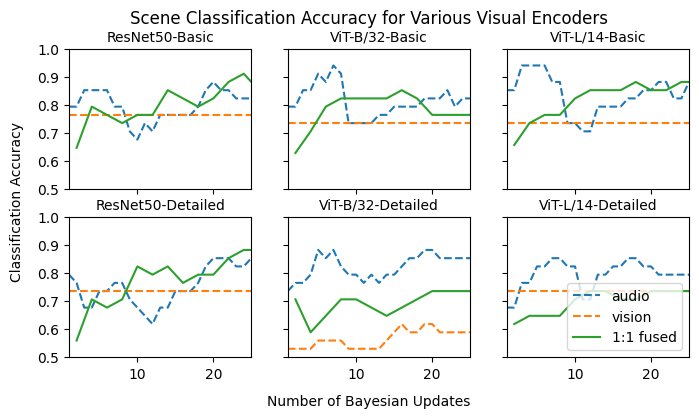

In [7]:
fig, axes = plt.subplots(2,3, sharex=True, sharey=True, figsize=(8,4))

for col_idx, model in enumerate(['ResNet50','ViT-B/32','ViT-L/14']):
    for row_idx,desc in enumerate(['Basic','Detailed']):
        ax = axes[row_idx, col_idx]
        ax.set_xlim((1,25))
        ax.set_ylim((.5,1.))
        ax.set_title(f"{model}-{desc}",fontsize=10)


        audio_mask = ((scene_recognition_results_df['Vision Backbone'] == model) &
                      (scene_recognition_results_df['Scene Description'] == desc) & 
                     (scene_recognition_results_df['Method'] == 'audio'))
        vision_mask = ((scene_recognition_results_df['Vision Backbone'] == model) &
                      (scene_recognition_results_df['Scene Description'] == desc) & 
                     (scene_recognition_results_df['Method'] == 'visual'))
        fused_mask = ((scene_recognition_results_df['Vision Backbone'] == model) &
                      (scene_recognition_results_df['Scene Description'] == desc) & 
                     (scene_recognition_results_df['Method'] == 'fused'))
        
        audio_data = scene_recognition_results_df[audio_mask]
        vision_data = scene_recognition_results_df[vision_mask]
        fused_data = scene_recognition_results_df[fused_mask]

        ax.plot(audio_data['Number of Updates'],audio_data['Accuracy'],linestyle='--',label='audio')
        ax.plot(vision_data['Number of Updates'],vision_data['Accuracy'],linestyle='--',label='vision')
        ax.plot(fused_data['Number of Updates'],fused_data['Accuracy'],label='1:1 fused')
ax.legend(loc="lower right")

fig.suptitle('Scene Classification Accuracy for Various Visual Encoders')
fig.text(0.5, 0.0, 'Number of Bayesian Updates', ha='center', va='center')
fig.text(0.06, 0.5, 'Classification Accuracy', ha='center', va='center', rotation='vertical')
fig.show()

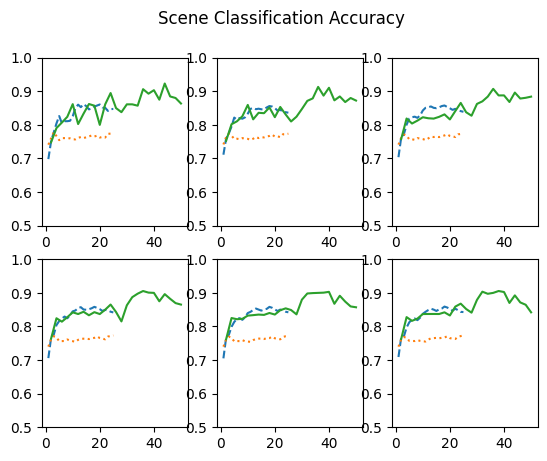

In [30]:
plot_idx = 1

n = np.arange(0,5,1)

plt.figure()
for col_idx, model in enumerate(['ResNet50','ViT-B/32','ViT-L/14']):
    for row_idx,desc in enumerate(['Basic','Detailed']):
        
        audio_mask = ((scene_recognition_results_df['Vision Backbone'] == model) &
                      (scene_recognition_results_df['Scene Description'] == desc) & 
                     (scene_recognition_results_df['Method'] == 'audio'))
        vision_mask = ((scene_recognition_results_df['Vision Backbone'] == model) &
                      (scene_recognition_results_df['Scene Description'] == desc) & 
                     (scene_recognition_results_df['Method'] == 'visual'))
        fused_mask = ((scene_recognition_results_df['Vision Backbone'] == model) &
                      (scene_recognition_results_df['Scene Description'] == desc) & 
                     (scene_recognition_results_df['Method'] == 'fused'))
        
        audio_data = scene_recognition_results_df[audio_mask]
        vision_data = scene_recognition_results_df[vision_mask]
        fused_data = scene_recognition_results_df[fused_mask]
                
        plt.subplot(2, 3, plot_idx)
        plt.plot(audio_data['Number of Updates'],audio_data['Accuracy'],linestyle='--')
        plt.plot(vision_data['Number of Updates'],vision_data['Accuracy'],linestyle=':')
        plt.plot(fused_data['Number of Updates'],fused_data['Accuracy'])
        plt.ylim((.5,1.))

        
        plot_idx +=1
plt.suptitle('Scene Classification Accuracy')
plt.show()

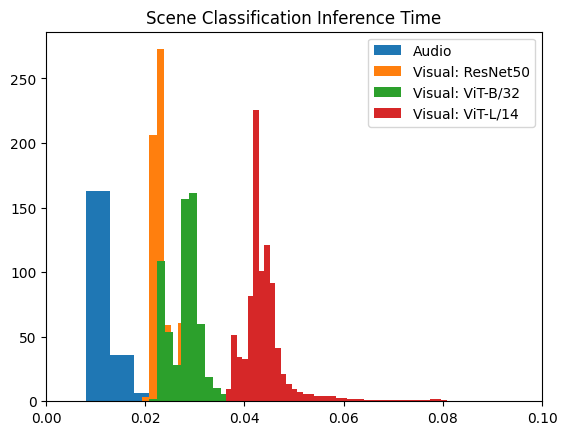

In [100]:
audio_inference_time_path = '../../results/exp0_obs_models/audio_scene_inference_times.json'
audio_inference_times = json.load(open(audio_inference_time_path))

rn50_basic_inference_time_path = '../../results/exp0_obs_models/overall/RN50_basic_description_inference_times.json'
rn50_detailed_inference_time_path = '../../results/exp0_obs_models/overall/RN50_detailed_description_inference_times.json'
rn50_basic_inference_times = json.load(open(rn50_basic_inference_time_path))
rn50_detailed_inference_times = json.load(open(rn50_detailed_inference_time_path))
rn50_inference_times = rn50_basic_inference_times['overall'][1:] + rn50_detailed_inference_times['overall'][1:]

vitb32_basic_inference_time_path = '../../results/exp0_obs_models/overall/ViT-B32_basic_description_inference_times.json'
vitb32_detailed_inference_time_path = '../../results/exp0_obs_models/overall/ViT-B32_detailed_description_inference_times.json'
vitb32_basic_inference_times = json.load(open(vitb32_basic_inference_time_path))
vitb32_detailed_inference_times = json.load(open(vitb32_detailed_inference_time_path))
vitb32_inference_times = vitb32_basic_inference_times['overall'][1:] + vitb32_detailed_inference_times['overall'][1:]

vitl14_basic_inference_time_path = '../../results/exp0_obs_models/overall/ViT-L14_basic_description_inference_times.json'
vitl14_detailed_inference_time_path = '../../results/exp0_obs_models/overall/ViT-L14_detailed_description_inference_times.json'
vitl14_basic_inference_times = json.load(open(vitl14_basic_inference_time_path))
vitl14_detailed_inference_times = json.load(open(vitl14_detailed_inference_time_path))
vitl14_inference_times = vitl14_basic_inference_times['overall'][1:] + vitl14_detailed_inference_times['overall'][1:]


plt.hist(audio_inference_times,bins=100,label='Audio',density=True)
plt.hist(rn50_inference_times,bins=100,label='Visual: ResNet50',density=True)
plt.hist(vitb32_inference_times,bins=100,label='Visual: ViT-B/32',density=True)
plt.hist(vitl14_inference_times,bins=100,label='Visual: ViT-L/14',density=True)
plt.title("Scene Classification Inference Time")
plt.xlim([0,.1])
plt.legend()
plt.show()

# Experiment 2: Hierarchical Commanding (Simultaneous Role & Command Classification)

## Role Recognition accuracy vs. number of updates by modality

In [47]:
# filepath = '../../../../hierarchical_cmd_results_artag_only.csv'
filepath = '../../results/exp2_hierarchical_cmd/role_rec/hierarchical_cmd_results.csv'

hierarchical_cmd_results_df = pd.read_csv(filepath,index_col=0)

hierarchical_cmd_results_df = hierarchical_cmd_results_df.dropna()


In [59]:
max_num_updates = 37

role_rec_results = {}

for method in ['artag','visual']:
    role_rec_results[method] = {}
    
    for scene in ['overall','campus','courtyard','lab','lobby']:
        role_rec_results[method][scene] = {}
        role_rec_results[method][scene]['true_pos_role_est'] = np.zeros((max_num_updates))
        role_rec_results[method][scene]['total_role_est'] = np.zeros((max_num_updates))

for method in ['artag','visual']:
    for scene in ['campus','courtyard','lab','lobby']:
        for role in ['supervisor','teammate','pedestrian']:
                for cmd_mode in ['artag','gest_verb','gesture','verbal']:
                    for cmd in ['move-in-reverse','move-forward','follow-me','rally','halt','advance','attention']:
    
                        # Get est roles from epoch
                        df_mask = ((hierarchical_cmd_results_df['scene']==scene) 
                                   & (hierarchical_cmd_results_df['role']==role)
                                   & (hierarchical_cmd_results_df['cmd_mode']==cmd_mode)
                                   & (hierarchical_cmd_results_df['role rec method']==method)
                                   & (hierarchical_cmd_results_df['cmd']==cmd))
                        est_role_df = hierarchical_cmd_results_df[df_mask]

                        if len(est_role_df)>0:
                            true_pos_mask = (est_role_df['role'] == est_role_df['estimated role'])
                                   
                            true_pos_role_est= np.zeros((max_num_updates))
                            true_pos_role_est[:len(est_role_df)] = true_pos_mask
                            
                            total_role_est = np.zeros((max_num_updates))
                            total_role_est[:len(est_role_df)] = np.ones(len(est_role_df))
        
                            role_rec_results[method]['overall']['true_pos_role_est'] += true_pos_role_est
                            role_rec_results[method][scene]['true_pos_role_est'] += true_pos_role_est
                            
                            role_rec_results[method]['overall']['total_role_est'] += total_role_est
                            role_rec_results[method][scene]['total_role_est'] += total_role_est


/tmp/ipykernel_2361515/3171062970.py:11: RuntimeWarning: invalid value encountered in divide
  acc = role_rec_results[method][scene]['true_pos_role_est']/ role_rec_results[method][scene]['total_role_est']
/tmp/ipykernel_2361515/3171062970.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


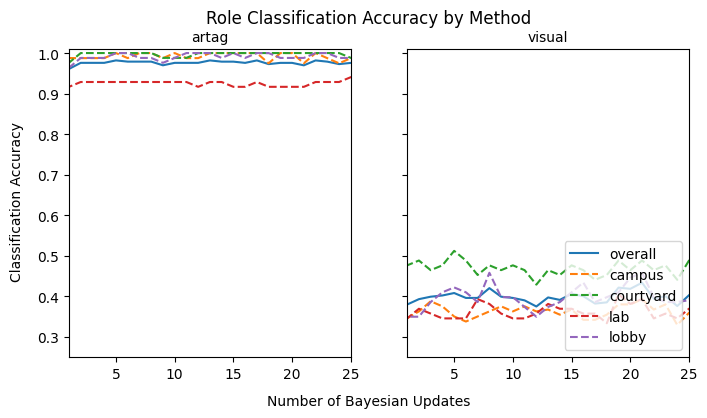

In [71]:
fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(8,4))

for idx, method in enumerate(['artag','visual']):
    ax = axes[idx]
    ax.set_xlim((1,25))
    ax.set_ylim((.25,1.01))
    ax.set_title(f"{method}",fontsize=10)

    ax.plot(role_rec_results[method]['overall']['true_pos_role_est'] / role_rec_results[method]['overall']['total_role_est'],linestyle='-',label='overall')
    for scene in ['campus','courtyard','lab','lobby']:
        acc = role_rec_results[method][scene]['true_pos_role_est']/ role_rec_results[method][scene]['total_role_est']
        ax.plot(acc,linestyle='--',label=scene)
        
ax.legend(loc="lower right")

fig.suptitle('Role Classification Accuracy by Method')
fig.text(0.5, 0.0, 'Number of Bayesian Updates', ha='center', va='center')
fig.text(0.06, 0.5, 'Classification Accuracy', ha='center', va='center', rotation='vertical')
fig.show()

# plt.xlabel('Number of updates')
# plt.ylabel('Role estimation accuracy')

In [134]:
# ARTAG role accuracy
overall_artag_ped_true_pos_mask = ((hierarchical_cmd_results_df['role rec method']=='artag') & (hierarchical_cmd_results_df['role']=='pedestrian') & (hierarchical_cmd_results_df['estimated role']=='pedestrian'))
overall_artag_teammate_true_pos_mask = ((hierarchical_cmd_results_df['role rec method']=='artag') &(hierarchical_cmd_results_df['role']=='teammate') & (hierarchical_cmd_results_df['estimated role']=='robot-teammate'))
overall_artag_supervisor_true_pos_mask = ((hierarchical_cmd_results_df['role rec method']=='artag') &(hierarchical_cmd_results_df['role']=='supervisor') & (hierarchical_cmd_results_df['estimated role']=='robot-supervisor'))

overall_artag_role_estimates = len(hierarchical_cmd_results_df)
overall_artag_ped_true_pos = len(hierarchical_cmd_results_df[overall_artag_ped_true_pos_mask])
overall_artag_teammate_true_pos = len(hierarchical_cmd_results_df[overall_artag_teammate_true_pos_mask])
overall_artag_supervisor_true_pos = len(hierarchical_cmd_results_df[overall_artag_supervisor_true_pos_mask])
overall_artag_true_pos = overall_artag_ped_true_pos + overall_artag_teammate_true_pos + overall_artag_supervisor_true_pos

overall_artag_role_accuracy = float(overall_artag_true_pos/overall_artag_role_estimates)


campus_artag_ped_true_pos_mask = ((hierarchical_cmd_results_df['scene']=='campus') & (hierarchical_cmd_results_df['role rec method']=='artag') & (hierarchical_cmd_results_df['role']=='pedestrian') & (hierarchical_cmd_results_df['estimated role']=='pedestrian'))
campus_artag_teammate_true_pos_mask = ((hierarchical_cmd_results_df['scene']=='campus') & (hierarchical_cmd_results_df['role rec method']=='artag') &(hierarchical_cmd_results_df['role']=='teammate') & (hierarchical_cmd_results_df['estimated role']=='robot-teammate'))
campus_artag_supervisor_true_pos_mask = ((hierarchical_cmd_results_df['scene']=='campus') & (hierarchical_cmd_results_df['role rec method']=='artag') &(hierarchical_cmd_results_df['role']=='supervisor') & (hierarchical_cmd_results_df['estimated role']=='robot-supervisor'))

campus_artag_role_estimates = len(hierarchical_cmd_results_df[(hierarchical_cmd_results_df['scene']=='campus') & (hierarchical_cmd_results_df['role rec method']=='artag')])
campus_artag_ped_true_pos = len(hierarchical_cmd_results_df[campus_artag_ped_true_pos_mask])
campus_artag_teammate_true_pos = len(hierarchical_cmd_results_df[campus_artag_teammate_true_pos_mask])
campus_artag_supervisor_true_pos = len(hierarchical_cmd_results_df[campus_artag_supervisor_true_pos_mask])
campus_artag_true_pos = campus_artag_ped_true_pos + campus_artag_teammate_true_pos + campus_artag_supervisor_true_pos

campus_artag_role_accuracy = float(campus_artag_true_pos/campus_artag_role_estimates)


courtyard_artag_ped_true_pos_mask = ((hierarchical_cmd_results_df['scene']=='courtyard') & (hierarchical_cmd_results_df['role rec method']=='artag') & (hierarchical_cmd_results_df['role']=='pedestrian') & (hierarchical_cmd_results_df['estimated role']=='pedestrian'))
courtyard_artag_teammate_true_pos_mask = ((hierarchical_cmd_results_df['scene']=='courtyard') & (hierarchical_cmd_results_df['role rec method']=='artag') &(hierarchical_cmd_results_df['role']=='teammate') & (hierarchical_cmd_results_df['estimated role']=='robot-teammate'))
courtyard_artag_supervisor_true_pos_mask = ((hierarchical_cmd_results_df['scene']=='courtyard') & (hierarchical_cmd_results_df['role rec method']=='artag') &(hierarchical_cmd_results_df['role']=='supervisor') & (hierarchical_cmd_results_df['estimated role']=='robot-supervisor'))

courtyard_artag_role_estimates = len(hierarchical_cmd_results_df[(hierarchical_cmd_results_df['scene']=='courtyard') & (hierarchical_cmd_results_df['role rec method']=='artag')])
courtyard_artag_ped_true_pos = len(hierarchical_cmd_results_df[courtyard_artag_ped_true_pos_mask])
courtyard_artag_teammate_true_pos = len(hierarchical_cmd_results_df[courtyard_artag_teammate_true_pos_mask])
courtyard_artag_supervisor_true_pos = len(hierarchical_cmd_results_df[courtyard_artag_supervisor_true_pos_mask])
courtyard_artag_true_pos = courtyard_artag_ped_true_pos + courtyard_artag_teammate_true_pos + courtyard_artag_supervisor_true_pos

courtyard_artag_role_accuracy = float(courtyard_artag_true_pos/courtyard_artag_role_estimates)


lab_artag_ped_true_pos_mask = ((hierarchical_cmd_results_df['scene']=='lab') & (hierarchical_cmd_results_df['role rec method']=='artag') & (hierarchical_cmd_results_df['role']=='pedestrian') & (hierarchical_cmd_results_df['estimated role']=='pedestrian'))
lab_artag_teammate_true_pos_mask = ((hierarchical_cmd_results_df['scene']=='lab') & (hierarchical_cmd_results_df['role rec method']=='artag') &(hierarchical_cmd_results_df['role']=='teammate') & (hierarchical_cmd_results_df['estimated role']=='robot-teammate'))
lab_artag_supervisor_true_pos_mask = ((hierarchical_cmd_results_df['scene']=='lab') & (hierarchical_cmd_results_df['role rec method']=='artag') &(hierarchical_cmd_results_df['role']=='supervisor') & (hierarchical_cmd_results_df['estimated role']=='robot-supervisor'))

lab_artag_role_estimates = len(hierarchical_cmd_results_df[(hierarchical_cmd_results_df['scene']=='lab') & (hierarchical_cmd_results_df['role rec method']=='artag')])
lab_artag_ped_true_pos = len(hierarchical_cmd_results_df[lab_artag_ped_true_pos_mask])
lab_artag_teammate_true_pos = len(hierarchical_cmd_results_df[lab_artag_teammate_true_pos_mask])
lab_artag_supervisor_true_pos = len(hierarchical_cmd_results_df[lab_artag_supervisor_true_pos_mask])
lab_artag_true_pos = lab_artag_ped_true_pos + lab_artag_teammate_true_pos + lab_artag_supervisor_true_pos

lab_artag_role_accuracy = float(lab_artag_true_pos/lab_artag_role_estimates)


lobby_artag_ped_true_pos_mask = ((hierarchical_cmd_results_df['scene']=='lobby') & (hierarchical_cmd_results_df['role rec method']=='artag') & (hierarchical_cmd_results_df['role']=='pedestrian') & (hierarchical_cmd_results_df['estimated role']=='pedestrian'))
lobby_artag_teammate_true_pos_mask = ((hierarchical_cmd_results_df['scene']=='lobby') & (hierarchical_cmd_results_df['role rec method']=='artag') &(hierarchical_cmd_results_df['role']=='teammate') & (hierarchical_cmd_results_df['estimated role']=='robot-teammate'))
lobby_artag_supervisor_true_pos_mask = ((hierarchical_cmd_results_df['scene']=='lobby') & (hierarchical_cmd_results_df['role rec method']=='artag') &(hierarchical_cmd_results_df['role']=='supervisor') & (hierarchical_cmd_results_df['estimated role']=='robot-supervisor'))

lobby_artag_role_estimates = len(hierarchical_cmd_results_df[(hierarchical_cmd_results_df['scene']=='lobby') & (hierarchical_cmd_results_df['role rec method']=='artag')])
lobby_artag_ped_true_pos = len(hierarchical_cmd_results_df[lobby_artag_ped_true_pos_mask])
lobby_artag_teammate_true_pos = len(hierarchical_cmd_results_df[lobby_artag_teammate_true_pos_mask])
lobby_artag_supervisor_true_pos = len(hierarchical_cmd_results_df[lobby_artag_supervisor_true_pos_mask])
lobby_artag_true_pos = lobby_artag_ped_true_pos + lobby_artag_teammate_true_pos + lobby_artag_supervisor_true_pos

lobby_artag_role_accuracy = float(lobby_artag_true_pos/lobby_artag_role_estimates)

In [135]:
columns = ['AR Tag']
index = ['Campus','Courtyard','Lab','Lobby','Overall']

role_rec_results_df = pd.DataFrame(index=index,columns=columns)
role_rec_results_df.at['Campus','AR Tag'] = campus_artag_role_accuracy
role_rec_results_df.at['Courtyard','AR Tag'] = courtyard_artag_role_accuracy
role_rec_results_df.at['Lab','AR Tag'] = lab_artag_role_accuracy
role_rec_results_df.at['Lobby','AR Tag'] = lobby_artag_role_accuracy
role_rec_results_df.at['Overall','AR Tag'] = overall_artag_role_accuracy

In [136]:
role_rec_results_df

,AR Tag
Campus,0.962366
Courtyard,0.985413
Lab,0.936995
Lobby,0.985484
Overall,0.967688


## Command Recognition

In [137]:
hierarchical_cmd_results_df

,Unnamed: 0,config,scene,role,cmd_mode,cmd,role rec method,cmd rec method,stamp,object id,object class,estimated role,estimated command
0,0,config/exp2_cfgs/exp2_ar_role_ar_cmd.yaml,lab,supervisor,artag,move-in-reverse,artag,artag,0.000000e+00,NaN,NaN,NaN,NaN
1,1,config/exp2_cfgs/exp2_ar_role_ar_cmd.yaml,lab,supervisor,artag,move-in-reverse,artag,artag,1.720996e+09,0.0,person,robot-supervisor,move-in-reverse
2,2,config/exp2_cfgs/exp2_ar_role_ar_cmd.yaml,lab,supervisor,artag,move-in-reverse,artag,artag,1.720996e+09,0.0,person,robot-supervisor,move-in-reverse
3,3,config/exp2_cfgs/exp2_ar_role_ar_cmd.yaml,lab,supervisor,artag,move-in-reverse,artag,artag,1.720996e+09,0.0,person,robot-supervisor,move-in-reverse
4,4,config/exp2_cfgs/exp2_ar_role_ar_cmd.yaml,lab,supervisor,artag,move-in-reverse,artag,artag,1.720996e+09,0.0,person,robot-supervisor,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2409,2409,config/exp2_cfgs/exp2_ar_role_ar_cmd.yaml,lobby,teammate,artag,attention,artag,artag,1.721415e+09,0.0,person,robot-teammate,none
2410,2410,config/exp2_cfgs/exp2_ar_role_ar_cmd.yaml,lobby,teammate,artag,attention,artag,artag,1.721415e+09,0.0,person,robot-teammate,none
2411,2411,config/exp2_cfgs/exp2_ar_role_ar_cmd.yaml,lobby,teammate,artag,attention,artag,artag,1.721415e+09,0.0,person,robot-teammate,none
2412,2412,config/exp2_cfgs/exp2_ar_role_ar_cmd.yaml,lobby,teammate,artag,attention,artag,artag,1.721415e+09,0.0,person,robot-teammate,none


In [190]:
# Helper functions
def count_recognized_commands(cmd_rec_mask):
    count=0
    last_state = False
    
    for cmd_rec in cmd_rec_mask:
        if ((cmd_rec == False) & (last_state == True)):
            count+=1

        last_state = cmd_rec

    return count

# Initialize df
rows = ['campus','courtyard','lab','lobby','overall']
cols = ['artag expected cmds','artag received commands','artag accuracy rate']
results_df = pd.DataFrame(np.zeros((len(rows),len(cols))),index=rows,columns=cols)


# Populate DF
for cmd_modality in ['artag']:
    for scene in ['campus','courtyard','lab','lobby']:
        for role in ['pedestrian','supervisor','teammate']:
            for actual_cmd in ['advance','attention','follow-me','halt','move-forward','move-in-reverse','rally']:

                cmd_series_mask = ((hierarchical_cmd_results_df['scene']==scene) & 
                                   (hierarchical_cmd_results_df['cmd']==actual_cmd) & 
                                   (hierarchical_cmd_results_df['role']==role) & 
                                   (hierarchical_cmd_results_df['cmd_mode']==cmd_modality))
        
                command_series_df = hierarchical_cmd_results_df[cmd_series_mask]

                cmd_recognized_mask = command_series_df['estimated command'] == actual_cmd

                results_df.loc[scene,'%s expected cmds' % cmd_modality] += round(len(command_series_df)/6)
                results_df.loc['overall','%s expected cmds' % cmd_modality] += round(len(command_series_df)/6)

                results_df.loc[scene,'%s received commands' % cmd_modality] += count_recognized_commands(cmd_recognized_mask)
                results_df.loc['overall','%s received commands' % cmd_modality] += count_recognized_commands(cmd_recognized_mask)

                # print(f"{scene}-{role}-{actual_cmd}")
                # print(count_recognized_commands(cmd_recognized_mask))
                # print(len(command_series_df))
                # print()

    results_df['%s accuracy rate' % cmd_modality] = results_df['%s received commands' % cmd_modality]/results_df['%s expected cmds' % cmd_modality]

In [191]:
results_df

,artag expected cmds,artag received commands,artag accuracy rate
campus,92.0,33.0,0.358696
courtyard,105.0,101.0,0.961905
lab,105.0,72.0,0.685714
lobby,105.0,84.0,0.800000
overall,407.0,290.0,0.712531
